# Image Regression
>In this tutorial, we will train a model to predict the center of a human head.

Image Regression means the input of our model is an image and the output is a number. One application is to input an image and predict the key points of a human's head. Applications like Snapchat use this technology to overlay a mast on a human's face. In this tutorial we will train a simplifed model that only predict the center of a human's head.

First, we need to import the dataset we need. 

In [ ]:
from fastai.vision.all import *

data_path = untar_data(URLs.BIWI_HEAD_POSE)

/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 6): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  Expected in: /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extensio

Let's look at how this dataset is structured

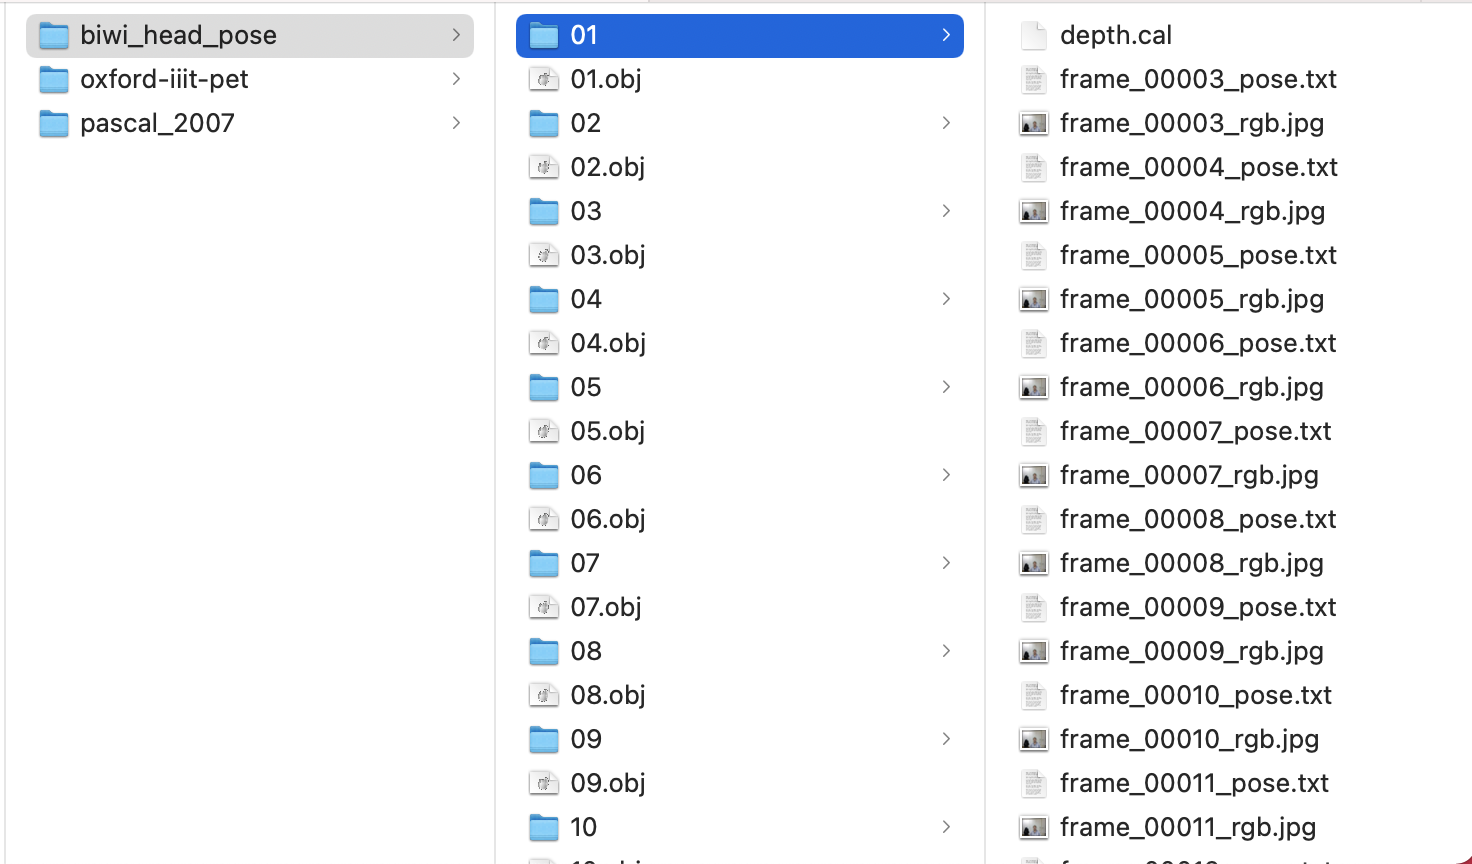

Each person's files are stored in a separate folder. The first persion's files are stored in the 01 folder , the second persion's files are stored in the 02 folder, and so on. We don't need the .obj files for our model, so we will ignore these files for now. Inside each person's folder, we have some jpeg files, some pose files, and a .cal file. The jpeg files are the images we feed into our model. The post files are used to label our image. Let's look at an image from this dataset.

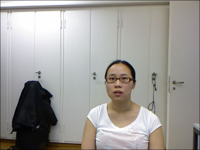

In [ ]:
image_paths = get_image_files(data_path)
img = PILImage.create(image_paths[0])
img.to_thumb(200)

We can start building our dataset step by step

In [ ]:
data = DataBlock(get_items=get_image_files).datasets(data_path)
x, y = data.train[0]
x, y

(Path('/Users/jerryyu/.fastai/data/biwi_head_pose/08/frame_00672_rgb.jpg'),
 Path('/Users/jerryyu/.fastai/data/biwi_head_pose/08/frame_00672_rgb.jpg'))

We got a path for x which is good. Later on when we pass ImageBlock to blocks, fastai will help us convert it to a PIL image. We need to define some functions to get the correct values for y. First, we define a function to get the pose file path based on the jpeg file path. 

In [ ]:
def img2pose(image_path):
    return Path(str(image_path)[:-7]+'pose.txt')

In [ ]:
img2pose(x)

Path('/Users/jerryyu/.fastai/data/biwi_head_pose/08/frame_00672_pose.txt')

Now we know where to find the pose file, we can define a function to get the center of the head in an image. 

In [ ]:
cal = np.genfromtxt(data_path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [ ]:
get_ctr(x)

tensor([350.7517, 275.2747])

We can then pass get_ctr to get_y in our DataBlock call.

In [ ]:
data = DataBlock(
    get_items=get_image_files,
    get_y = get_ctr
).datasets(data_path)
x, y = data.train[0]
x, y

(Path('/Users/jerryyu/.fastai/data/biwi_head_pose/15/frame_00465_rgb.jpg'),
 tensor([348.8435, 303.9288]))

Now we can specify our input and output blocks so that fastai can do the proper conversion for us. 

In [ ]:
data = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr
).datasets(data_path)
x, y = data.train[0]
x, y

(PILImage mode=RGB size=640x480, TensorPoint([[357.7530, 306.4343]]))

We specify the output is a PointBlock so that fastai knows that the labels represent coordinates and when we do image augmentation, fastai will do the same augmentation to the labels. We are now ready to create our dataloaders. 

One thing we need to pay attention to is we can't randomly split the data to create the training and validation set because the same person will appear in both datasets. We want the validation set to contain people our model has never seen during training. We need to specify a splitter in our DataBlock. We will also add augmentation to help train our model and resize our images to make training faster. 

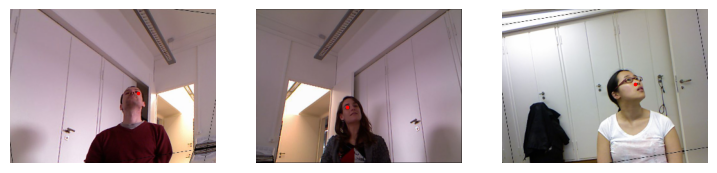

In [ ]:
dls = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda image_path: image_path.parent.name == '13'),
    batch_tfms = aug_transforms(size=(240,320))
).dataloaders(data_path)
dls.show_batch(max_n=3)

We are now ready to create our learner

In [ ]:
learner = vision_learner(dls, resnet18, y_range=(-1,1))
learner.fine_tune(2)

/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,0.129507,0.008684,34:23


epoch,train_loss,valid_loss,time
0,0.007625,0.002542,44:54
1,0.003237,0.000435,45:08


We specify y_range to let fastai know that the label is between -1 and 1 as coordinate in fastai is between -1 and 1. Let's look at some of the preditions on our validaiton set. 

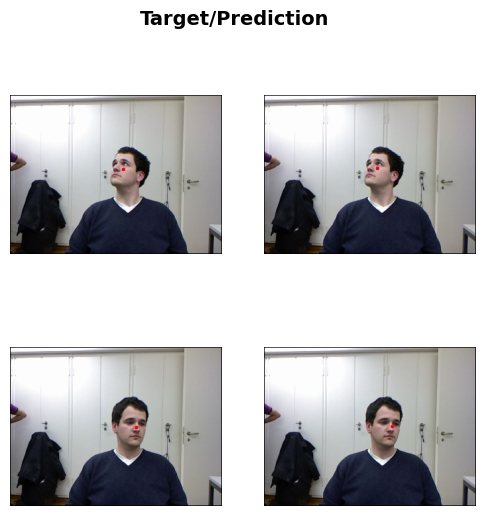

In [ ]:
learner.show_results(max_n=2)

That looks pretty accurate. Let's see how well the model can generalize on images downloaded from the Internet. test_person.jpg and test_persion_2.jpg are images I downloaded from [pexels](https://www.pexels.com/)

In [ ]:
prediction = learner.predict('../images/test_person.jpg')
prediction

(TensorPoint([[179.6764, 114.6520]]),
 TensorBase([ 0.1230, -0.0446]),
 TensorBase([ 0.1230, -0.0446]))

There are two ways to show the output on the test image. One way is to use matplotlib directly. The prediction will output the coordinate of the key point and the coordinate is based on the resized image, so before plotting the prediction on the test image, we need to resize the image.

[<matplotlib.lines.Line2D>]

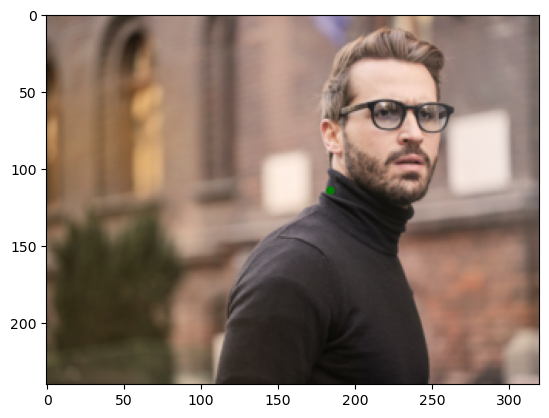

In [ ]:
import matplotlib.pyplot as plt

rsz = Resize((240, 320))
image = PILImage.create('../images/test_person.jpg')
rsz_image = rsz(image)
x = prediction[0][0][0]
y = prediction[0][0][1]
plt.imshow(rsz_image)
plt.plot(x, y, 'og', markersize=5)

The second way is to use the show_image method from fastai. 

In [ ]:
prediction = learner.predict('../images/test_person_2.jpg')
prediction

(TensorPoint([[183.4863, 113.3780]]),
 TensorBase([ 0.1468, -0.0552]),
 TensorBase([ 0.1468, -0.0552]))

[<matplotlib.lines.Line2D>]

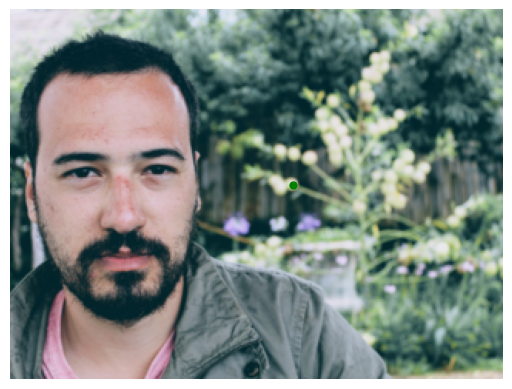

In [ ]:
rsz = Resize((240, 320))
image = PILImage.create('../images/test_person_2.jpg')
ax = plt.subplot()
show_image(rsz(image), ax=ax)
x = prediction[0][0][0]
y = prediction[0][0][1]
plt.plot(x, y, 'og', markersize=5)

Our model did very well on the validation set but not well on test images downloaded from the web. This is a problem of overfitting. Looking at our training data, the head position of all the images are relatively center. Also all the images were taken from the same camera in the same room. To improve our model, we can add more variation to our training data like changing the head location in an image or use images taken from different cameras and different backgrounds. 

[<matplotlib.lines.Line2D>]

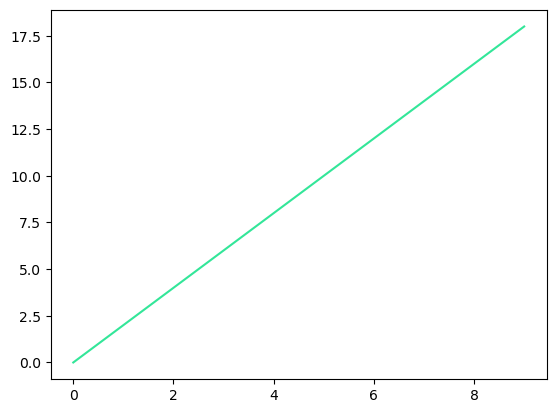

In [ ]:
import matplotlib.pyplot as plt
import numpy

x = np.arange(10)
y = x * 2
plt.plot(x, y, color=(0.2, 0.9, 0.6))

In [ ]:
learner = load_learner('model.pkl')

def predict(image):
    # Run the model to get the prediciton
    prediction = learner.predict(image)
    
    # Create a figure to show the prediction
    rsz = Resize((240, 320))
    image = PILImage.create(image)
    rsz_image = rsz(image)
    x = prediction[0][0][0]
    y = prediction[0][0][1]
    fig, ax = plt.subplots()
    plt.imshow(rsz_image)
    plt.plot(x, y, 'og', markersize=5)
    
    # Save the figure to a np array
    data = fig2data(fig)
    
    return data

interface = gr.Interface(fn=predict, inputs='image', outputs='image')
interface.launch()


Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB
Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.


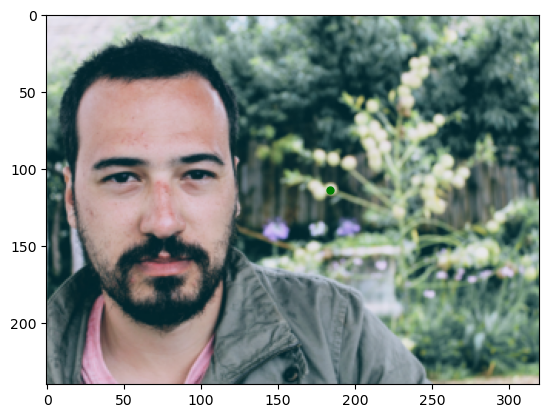

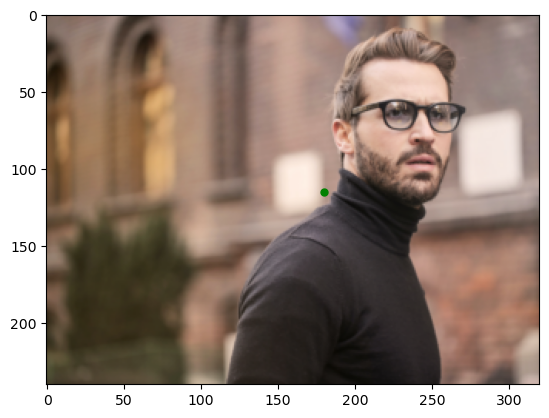

In [ ]:
learner.export('model.pkl')